In [24]:
import websocket
import pandas as pd
import requests
from pandas.io.json import json_normalize
import json
from code_ref import get_keys
from code_ref import findata
from code_ref import FinnhubRequestException
from code_ref import FinnhubAPIException
import time
import threading
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
from ratelimit import limits
from ratelimiter import RateLimiter
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob

from sklearn.experimental import enable_iterative_imputer  
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## DataSet Construction

df = pd.read_csv('data_api/management1.csv')
df1 = pd.read_csv('data_api/margin1.csv')
df2 = pd.read_csv('data_api/growth1.csv')
df3 = pd.read_csv('data_api/valuation1.csv')
df4 = pd.read_csv('data_api/financialstrength1.csv')

In [26]:
df.drop(columns = ['Unnamed: 0'] , inplace = True)
df1.drop(columns = ['Unnamed: 0'] , inplace = True)
df2.drop(columns = ['Unnamed: 0'] , inplace = True)
df3.drop(columns = ['Unnamed: 0'] , inplace = True)
df4.drop(columns = ['Unnamed: 0'] , inplace = True)

In [27]:
df.dropna(subset =['symbol'], inplace = True)
df1.dropna(subset =['symbol'], inplace = True)
df2.dropna(subset = ['symbol'], inplace = True)
df3.dropna(subset = ['symbol'], inplace = True)
df4.dropna(subset = ['symbol'], inplace = True)

In [28]:
comb1 = pd.merge(df, df1, how = 'left', on = 'symbol').merge(df2, how = 'left', on = 'symbol').merge(df3, how = 'left', on = 'symbol').merge(df4, how = 'left', on = 'symbol')

In [29]:
remove = ['metricType_x', 'metricType_y', 'metricType']

In [30]:
comb1.drop(columns = remove, inplace = True)

In [31]:
comb1.shape

(8831, 89)

## Testing Iterative Imputer for NaN values

We elected to go for KNNImputer to fill in missing values with the rationale that similar companies in terms of ratios would be grouped within the matrix dimensions and provide accurate inputs that would not affect the clustering outcomes. 

### KNN to fill Null Values

In [14]:
X = comb1.iloc[:,1:89]
y_full = comb1.iloc[:,1:89]
N_SPLITS = 5


In [35]:
imputer = KNNImputer(n_neighbors = 20)

In [36]:
comb2 = imputer.fit_transform(X)

In [37]:
comb2

array([[7.38880000e-01, 7.49460000e-01, 4.01344600e+01, ...,
        1.55768000e+00, 1.19404800e+02, 1.21670700e+02],
       [6.29504500e-01, 6.14567000e-01, 9.11558750e+00, ...,
        5.24087000e-01, 1.61458000e+02, 1.61458000e+02],
       [1.44638000e+00, 1.44637000e+00, 8.78851000e+00, ...,
        8.63630000e-01, 6.73799500e+01, 6.73799500e+01],
       ...,
       [4.59832000e+00, 4.59832000e+00, 9.58863000e+00, ...,
        7.07650000e-01, 8.16128100e+01, 8.16128100e+01],
       [1.13807000e+00, 1.06326000e+00, 8.13695000e+00, ...,
        2.61130000e-01, 8.12866000e+00, 9.46215000e+00],
       [4.28800000e-01, 3.46300000e-01, 3.89363545e+01, ...,
        9.68392000e-01, 3.36664100e+03, 1.82633639e+03]])

In [38]:
tst = pd.DataFrame(comb2, index = [comb1.index, comb1.iloc[:,0]], columns = X.columns)

In [39]:
tst.reset_index(inplace = True)

In [41]:
tst.drop(tst.columns[0], axis = 1, inplace = True)

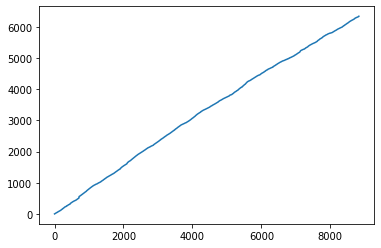

In [53]:
tst['metric.assetTurnoverAnnual'].cumsum().plot()

In [105]:
tst.head()

,symbol,metric.assetTurnoverAnnual,metric.assetTurnoverTTM,metric.inventoryTurnoverAnnual,metric.inventoryTurnoverTTM,metric.netIncomeEmployeeAnnual,metric.netIncomeEmployeeTTM,metric.receivablesTurnoverAnnual,metric.receivablesTurnoverTTM,metric.revenueEmployeeAnnual,...,metric.longTermDebt/equityAnnual,metric.longTermDebt/equityQuarterly,metric.netInterestCoverageAnnual,metric.netInterestCoverageTTM,metric.payoutRatioAnnual,metric.payoutRatioTTM,metric.quickRatioAnnual,metric.quickRatioQuarterly,metric.totalDebt/totalEquityAnnual,metric.totalDebt/totalEquityQuarterly
0,AAPL,0.738880,0.749460,40.134460,36.566870,410825.30,419905.10000,11.284440,13.71081,1934379.0,...,101.45760,104.66210,22.568915,22.538062,25.570070,24.48937,1.501290,1.557680,119.40480,121.67070
1,BAC,0.629505,0.614567,9.115588,10.783792,133155.30,69181.74465,9.857896,7.81659,442932.0,...,81.79525,81.79525,23.522583,24.086032,23.640280,23.64028,0.524087,0.524087,161.45800,161.45800
2,AMZN,1.446380,1.446370,8.788510,8.788510,16052.58,14538.85000,15.074940,15.07489,388131.4,...,65.27393,65.27393,18.933590,18.956980,36.943664,0.00000,0.863630,0.863630,67.37995,67.37995
3,T,0.334450,0.334450,29.863710,6.369177,58268.48,60873.98000,6.973920,6.97392,705031.1,...,82.13450,82.13450,3.773710,3.745440,108.115100,108.11510,0.753100,0.540961,88.56048,88.56048
4,GOOGL,0.636350,0.636350,68.277300,68.277300,315551.10,288841.80000,7.012260,7.01226,1487178.0,...,2.26070,2.26070,22.451458,23.180339,0.000000,0.00000,3.351960,3.351960,2.26070,2.26070


### Iterative Imputer & Fancy Impute

#### IterativeTest

In [15]:
N_SPLITS = 5
rng = np.random.RandomState(0)

In [16]:
X1 = X.dropna().to_numpy()
X_full = X.to_numpy() #taking continuous subset of variables
y_full = X['metric.assetTurnoverAnnual'].to_numpy()

n_samples, n_features = X_full.shape
REGRESSOR = RandomForestRegressor(random_state=0)


In [120]:
imp_mean = IterativeImputer(estimator = dt, random_state=0)

In [121]:
imp_mean.fit(X_full)

/anaconda3/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


IterativeImputer(add_indicator=False,
                 estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                                 max_depth=None,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 presort='deprecated',
                                                 random_state=None,
                                                 splitter='best'),
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, ma

In [122]:
comb3 = imp_mean.transform(X_full)

In [123]:
tst1 = pd.DataFrame(comb3, index = [comb1.index, comb1.iloc[:,0]], columns = X.columns)


In [23]:
tst1.reset_index(inplace = True)
tst1.drop(tst1.columns[0], axis = 1, inplace = True)
tst1.head()

NameError: name 'tst1' is not defined

#### Combination

##### KNN: 

- Nearest neighbor imputations which weights samples using the mean squared difference on features for which two rows both have observed data.

##### SoftImpute: 

- Matrix completion by iterative soft thresholding of SVD decompositions. Inspired by the softImpute package for R, which is based on Spectral Regularization Algorithms for Learning Large Incomplete Matrices

##### NuclearNormMinimization: 

- Simple implementation of Exact Matrix Completion via Convex Optimization by Emmanuel Candes and Benjamin Recht using cvxpy. Too slow for large matrices.



In [4]:
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler

In [21]:
# X_filled_knn = KNN(k=3).fit_transform(X_full)
# # X_filled_nnm = NuclearNormMinimization().fit_transform(X_full)
# X_incomplete_normalized = BiScaler().fit_transform(X_full)
# # X_filled_softimpute = SoftImpute().fit_transform(X_incomplete_normalized)



In [19]:
# # nnm_mse = ((X_filled_nnm[missing_mask] - X1[missing_mask]) ** 2).mean()
# # print("Nuclear norm minimization MSE: %f" % nnm_mse)

# # softImpute_mse = ((X_filled_softimpute[missing_mask] - X1[missing_mask]) ** 2).mean()
# # print("SoftImpute MSE: %f" % softImpute_mse)

# knn_mse = ((X_filled_knn[missing_mask] - X1[missing_mask]) ** 2).mean()
# print("knnImpute MSE: %f" % knn_mse)

## Dimensionality Reduction Using PCA

We are able to reduce the dimensions of the dataset using PCA. From the below 96% of the variance is explained by the first 55 principal components.

In [69]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
scaled = sc.fit_transform(comb2)

In [97]:
pca = PCA(n_components = None)

In [98]:
X2D = pca.fit_transform(scaled)

In [99]:
pca.explained_variance_ratio_.sum()

0.9999999999999998

In [100]:
len(pca.explained_variance_ratio_)

88

In [101]:
df = pd.DataFrame(pca.explained_variance_ratio_)

## Clustering

In [113]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 50, random_state =0).fit(comb2)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

### Elbow Method

This method indicates that four 3-4 clusters may be able to clear 

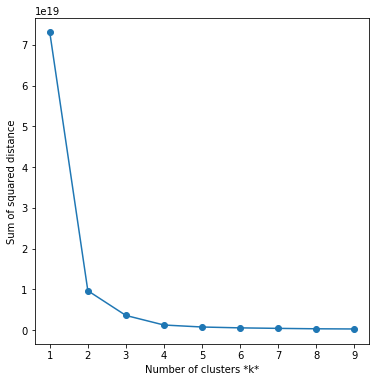

In [112]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(comb2)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');